# Load the Dataset

In [11]:
import pandas as pd
#encode categorical and numerical columns with label and ordinal encoding
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import numpy as np
#do random forest classification
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#import train_test_split
from sklearn.model_selection import train_test_split,PredefinedSplit

seed = 42
FILENAME = "train_dataset.csv"
# 1, 2 e 3
df = pd.read_csv(FILENAME, sep=",", low_memory=False)
df = df.dropna()
df = df.drop(columns=["label"])

# 4
df["src_bytes"] = df["src_bytes"].replace("0.0.0.0", np.nan).astype(float)
mean_src_bytes = df["src_bytes"].mean()
df["src_bytes"] = df["src_bytes"].fillna(mean_src_bytes)

# 5
df.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

# 6
y = df["type"]
df = df.drop(columns=["type"])

print(df.select_dtypes(include=['object']).shape)

# 7
oe = OrdinalEncoder()
df_oe = oe.fit_transform(df.select_dtypes(include=['object']))
df.loc[:, df.select_dtypes(include=['object']).columns] = df_oe
X = df.to_numpy()

# 8
le = LabelEncoder()
y = le.fit_transform(y)

indeces = np.arange(X.shape[0])
train_idx, val_idx = train_test_split(indeces, test_size=0.2, stratify=y, random_state=seed)
val_idx, test_idx = train_test_split(val_idx, test_size=0.5, stratify=y[val_idx], random_state=seed)

fold = np.zeros(X.shape[0])
fold[train_idx] = -1
fold[val_idx] = 0
fold[test_idx] = 1

ps = PredefinedSplit(fold)
ps.get_n_splits()

X_test = X[test_idx,:]
y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

(617002, 27)


In [12]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

X = scaler.transform(X)

pca = PCA(n_components='mle')
pca.fit(X_train)
X = pca.transform(X)

# Apply PCA transformation to X_test and X_val
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)


# SVM

In [7]:
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# import pickle

# param_grid = {'C': [0.1, 1,10,100], 
#               'gamma': [1,0.1,0.01,0.001],
#               'kernel': ['rbf','sigmoid','linear']}  

# #cast x and y train in numpy arrays
# X_train = np.array(X_train)
# y_train = np.array(y_train)

# grid = GridSearchCV(SVC(random_state=seed), param_grid,verbose=10,cv=2,n_jobs=-1)
# grid.fit(X_train, y_train)
# file = open("svc.save","wb")
# pickle.dump(grid.best_estimator_, file)
# print("Best hypearparameters: ",grid.best_estimator_)
# print("Best performance:",  grid.best_score_)
# file.close()


# y_pred = grid.predict(X_test)

# #plot confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
# disp.plot()
# plt.show()

# #print classification report
# from sklearn.metrics import classification_report, balanced_accuracy_score
# print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in le.classes_]))

# #print the balanced accuracy
# print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))



# Random Forest

In [8]:
#import random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle

param_grid = {  'n_estimators': [100, 200],
                'criterion': ['gini', 'entropy']
                }  



grid = GridSearchCV(RandomForestClassifier(random_state=seed,n_jobs=-1), cv=ps, param_grid=param_grid,verbose=10)
grid.fit(X, y)
file = open("rf.save","wb")
pickle.dump(grid.best_estimator_, file)
print("Best hyperparameters: ",grid.best_estimator_)
print("Best performance:",  grid.best_score_)
file.close()


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV 1/2; 1/4] START criterion=gini, n_estimators=100............................
[CV 1/2; 1/4] END criterion=gini, n_estimators=100;, score=0.999 total time=  47.6s
[CV 2/2; 1/4] START criterion=gini, n_estimators=100............................
[CV 2/2; 1/4] END criterion=gini, n_estimators=100;, score=1.000 total time=  50.5s
[CV 1/2; 2/4] START criterion=gini, n_estimators=200............................
[CV 1/2; 2/4] END criterion=gini, n_estimators=200;, score=0.999 total time= 1.7min
[CV 2/2; 2/4] START criterion=gini, n_estimators=200............................
[CV 2/2; 2/4] END criterion=gini, n_estimators=200;, score=1.000 total time= 1.7min
[CV 1/2; 3/4] START criterion=entropy, n_estimators=100.........................
[CV 1/2; 3/4] END criterion=entropy, n_estimators=100;, score=0.999 total time= 1.1min
[CV 2/2; 3/4] START criterion=entropy, n_estimators=100.........................
[CV 2/2; 3/4] END criterion=entr

ValueError: X has 44 features, but RandomForestClassifier is expecting 42 features as input.

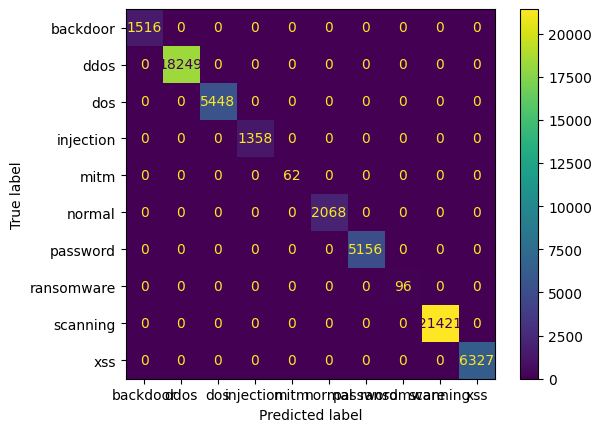

              precision    recall  f1-score   support

    backdoor       1.00      1.00      1.00      1516
        ddos       1.00      1.00      1.00     18249
         dos       1.00      1.00      1.00      5448
   injection       1.00      1.00      1.00      1358
        mitm       1.00      1.00      1.00        62
      normal       1.00      1.00      1.00      2068
    password       1.00      1.00      1.00      5156
  ransomware       1.00      1.00      1.00        96
    scanning       1.00      1.00      1.00     21421
         xss       1.00      1.00      1.00      6327

    accuracy                           1.00     61701
   macro avg       1.00      1.00      1.00     61701
weighted avg       1.00      1.00      1.00     61701



In [13]:
# do classification report
y_pred = grid.predict(X_test)

#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)

disp.plot()
plt.show()

from sklearn.metrics import classification_report, balanced_accuracy_score
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in le.classes_]))


In [26]:
#print classification report
from sklearn.metrics import classification_report, balanced_accuracy_score
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in le.classes_]))

#print the balanced accuracy
print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1507
         1.0       0.00      0.00      0.00     18197
         2.0       0.00      0.00      0.00      5541
         3.0       0.00      0.00      0.00      1289
         4.0       0.00      0.00      0.00        53
         5.0       0.03      1.00      0.06      2027
         6.0       0.00      0.00      0.00      5214
         7.0       0.00      0.00      0.00        84
         8.0       0.00      0.00      0.00     21390
         9.0       0.00      0.00      0.00      6399

    accuracy                           0.03     61701
   macro avg       0.00      0.10      0.01     61701
weighted avg       0.00      0.03      0.00     61701

Balanced accuracy:  0.1


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

# KNN

In [7]:
#do the same with knn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import pickle
param_grid = {'n_neighbors': [3,4,5,6,7,8,9,10,11],
                'metric': ['euclidean', 'manhattan'],
                'weights': ['uniform', 'distance'],}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3,verbose=10)


grid.fit(X, y)
#save the best model
print("Best hyperparameters: ",grid.best_estimator_)
print("Best performance:",  grid.best_score_)

#save the model with the best hyperparameters
file = open("knn.save","wb")
pickle.dump(grid.best_estimator_, file)
file.close()


#print classification report
from sklearn.metrics import classification_report, balanced_accuracy_score
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in le.classes_]))

#print the balanced accuracy
print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))


#plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_)
disp.plot()
plt.show()



Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3; 1/36] START metric=euclidean, n_neighbors=3, weights=uniform...........


c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\rinal\Desktop\UNIBO\DA\data-analytics\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[CV 1/3; 1/36] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.998 total time=  31.1s
[CV 2/3; 1/36] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 2/3; 1/36] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.998 total time=  33.2s
[CV 3/3; 1/36] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 3/3; 1/36] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.998 total time=  32.7s
[CV 1/3; 2/36] START metric=euclidean, n_neighbors=3, weights=distance..........
[CV 1/3; 2/36] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.999 total time=  30.5s
[CV 2/3; 2/36] START metric=euclidean, n_neighbors=3, weights=distance..........
[CV 2/3; 2/36] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.999 total time=  30.2s
[CV 3/3; 2/36] START metric=euclidean, n_neighbors=3, weights=distance..........
[CV 3/3; 2/36] END metric=euclidean, n_neighbors=3, weights=distance;, score=0.999 total

ValueError: Found input variables with inconsistent numbers of samples: [61701, 61700]